In [1]:
#|default_exp init

# Initialization

In [2]:
#|export
import pickle,gzip,math,os,time,shutil,torch,matplotlib as mpl,numpy as np,matplotlib.pyplot as plt
import sys,gc,traceback
import fastcore.all as fc
from collections.abc import Mapping
from pathlib import Path
from operator import attrgetter,itemgetter
from functools import partial
from copy import copy
from contextlib import contextmanager

import torchvision.transforms.functional as TF,torch.nn.functional as F
from torch import tensor,nn,optim
from torch.utils.data import DataLoader,default_collate
from torch.nn import init
from torcheval.metrics import MulticlassAccuracy
from datasets import load_dataset,load_dataset_builder

from miniai.datasets import *
from miniai.conv import *
from miniai.learner import *
from miniai.activations import *

In [3]:
from fastcore.test import test_close

torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)
torch.manual_seed(1)

import logging
logging.disable(logging.WARNING)

set_seed(42)

In [4]:
xl,yl = 'image','label'
name = "fashion_mnist"
dsd = load_dataset(name)

@inplace
def transformi(b): b[xl] = [TF.to_tensor(o) for o in b[xl]]

bs = 1024
tds = dsd.with_transform(transformi)

dls = DataLoaders.from_dd(tds, bs, num_workers=4)
dt = dls.train
xb,yb = next(iter(dt))
xb.shape,yb[:10]

(torch.Size([1024, 1, 28, 28]), tensor([5, 7, 4, 7, 3, 8, 9, 5, 3, 1]))

In [5]:
def get_model():
    return nn.Sequential(conv(1 ,8), conv(8 ,16), conv(16,32), conv(32,64),
                         conv(64,10, act=False), nn.Flatten()).to(def_device)

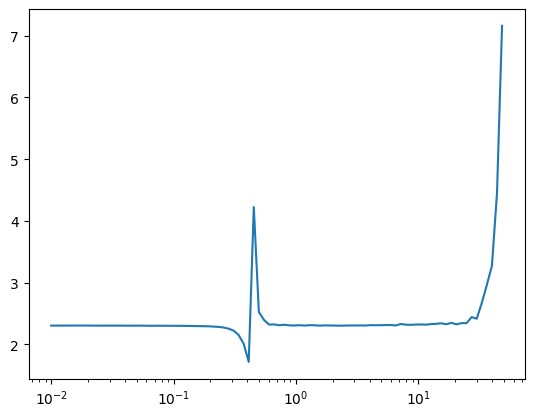

In [6]:
MomentumLearner(get_model(), dls, F.cross_entropy, cbs=[DeviceCB()]).lr_find(gamma=1.1, start_lr=1e-2)

In [7]:
metrics = MetricsCB(accuracy=MulticlassAccuracy())
astats = ActivationStats(fc.risinstance(nn.ReLU))
cbs = [DeviceCB(), metrics, ProgressCB(plot=True), astats]
learn = MomentumLearner(get_model(), dls, F.cross_entropy, lr=0.2, cbs=cbs)

accuracy,loss,epoch,train
0.296,1.881,0,train
0.677,0.837,0,eval


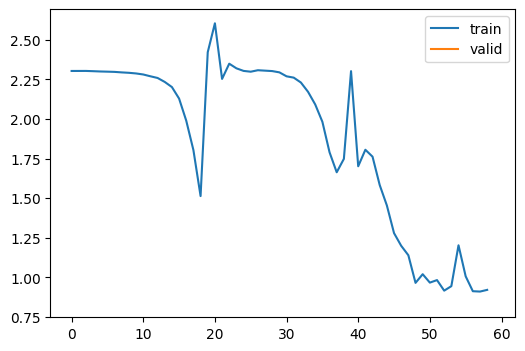

In [8]:
learn.fit(1)

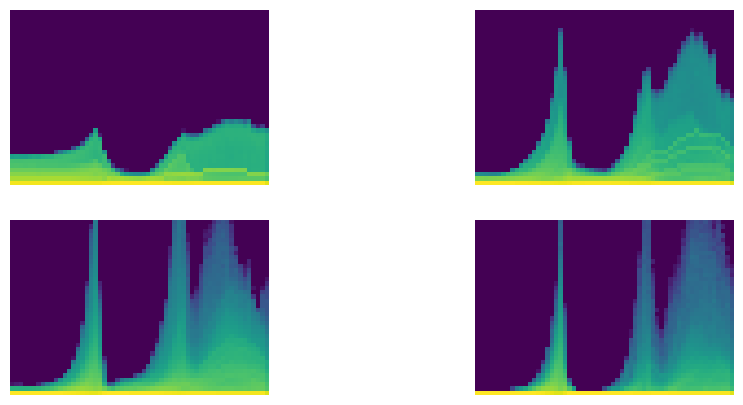

In [9]:
astats.color_dim()

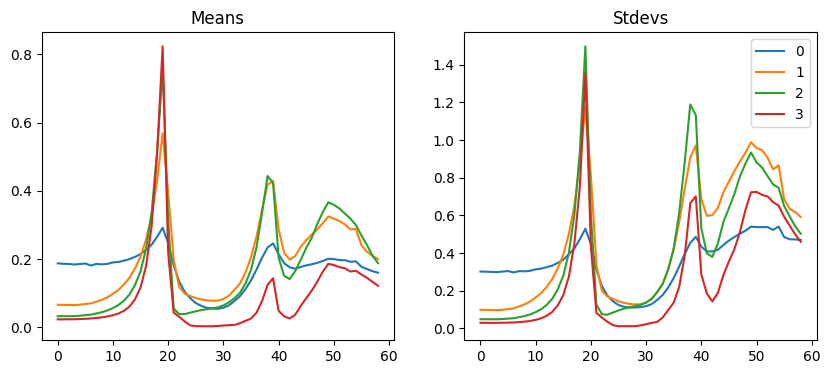

In [10]:
astats.plot_stats()

In [11]:
#|export
def clean_ipython_hist():
    # Code in this function mainly copied from IPython source
    if not 'get_ipython' in globals(): return
    ip = get_ipython()
    user_ns = ip.user_ns
    ip.displayhook.flush()
    pc = ip.displayhook.prompt_count + 1
    for n in range(1, pc): user_ns.pop('_i'+repr(n),None)
    user_ns.update(dict(_i='',_ii='',_iii=''))
    hm = ip.history_manager
    hm.input_hist_parsed[:] = [''] * pc
    hm.input_hist_raw[:] = [''] * pc
    hm._i = hm._ii = hm._iii = hm._i00 =  ''

In [12]:
#|export
def clean_tb():
    # h/t Piotr Czapla
    if hasattr(sys, 'last_traceback'):
        traceback.clear_frames(sys.last_traceback)
        delattr(sys, 'last_traceback')
    if hasattr(sys, 'last_type'): delattr(sys, 'last_type')
    if hasattr(sys, 'last_value'): delattr(sys, 'last_value')

In [13]:
#|export
def clean_mem():
    clean_tb()
    clean_ipython_hist()
    gc.collect()
    torch.cuda.empty_cache()

## Glorot/Xavier init

### The Problem Xavier Initialization Solves:

In deep neural networks, especially those with many layers, the scale of weights can dramatically impact how gradients propagate during backpropagation. If the weights are initialized too large, the gradients may explode, leading to unstable updates. If the weights are initialized too small, gradients may vanish, making it difficult for the network to learn.

Xavier initialization is designed to keep the variance of activations and gradients in a manageable range as they propagate through the network.

### The Xavier Initialization Formula:

For a neuron with $n_{\text{in}}$ input connections (number of incoming connections), the Xavier initialization sets the weights according to:

$$
W \sim \mathcal{U}\left( -\frac{1}{\sqrt{n_{\text{in}}}}, \frac{1}{\sqrt{n_{\text{in}}}} \right)
$$

Where:
- $\mathcal{U}$ is the uniform distribution.
- $n_{\text{in}}$ is the number of input neurons to a given layer.
- The weights are sampled from a uniform distribution between $-\frac{1}{\sqrt{n_{\text{in}}}}$ and $\frac{1}{\sqrt{n_{\text{in}}}}$.

Alternatively, for a normal distribution (Gaussian), the weights are initialized as:

$$
W \sim \mathcal{N}\left( 0, \frac{1}{\sqrt{n_{\text{in}}}} \right)
$$

This ensures that the variance of the activations is controlled across layers and helps prevent gradients from growing too large or too small.

---

### Why It Works:

The idea behind Xavier initialization is based on maintaining the **variance of the activations** throughout the layers. If the weights are initialized in a way that keeps the activations' variance consistent, it reduces the chance of the gradients either exploding or vanishing as they propagate through the network.

#### Key Points:

- **Input-to-output variance consistency**: Xavier initialization aims to keep the variance of the input and output of each neuron relatively similar. By scaling the weights by $\frac{1}{\sqrt{n_{\text{in}}}}$, it ensures that the input signal doesn't blow up or shrink as it moves forward through the layers.
  
- **Balanced forward and backward propagation**: This initialization helps keep gradients in a healthy range during backpropagation, preventing exploding or vanishing gradients, which can otherwise slow down learning or lead to convergence issues.

---

### When to Use Xavier Initialization:

Xavier initialization is typically used for **activation functions like Sigmoid or Tanh**, which can suffer from the vanishing gradient problem if weights are not properly initialized. For **ReLU** or its variants (e.g., Leaky ReLU), **He initialization** is often preferred because it accounts for the fact that ReLU neurons output zero for half of their inputs.

---

### Example in PyTorch:

In PyTorch, you can apply Xavier initialization using the built-in function `torch.nn.init.xavier_uniform_` or `torch.nn.init.xavier_normal_`.

Example code for Xavier initialization:

```python
import torch
import torch.nn as nn

# Example layer
layer = nn.Linear(in_features=256, out_features=128)

# Apply Xavier Uniform initialization
torch.nn.init.xavier_uniform_(layer.weight)

# Or apply Xavier Normal initialization
torch.nn.init.xavier_normal_(layer.weight)

In [14]:
x = torch.randn(200, 100)
for i in range(50): x = x @ torch.randn(100,100)
x[0:5,0:5]

tensor([[nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan]])

The result is `nan`s everywhere. So maybe the scale of our matrix was too big, and we need to have smaller weights? But if we use too small weights, we will have the opposite problem—the scale of our activations will go from 1 to 0.1, and after 50 layers we'll be left with zeros everywhere:

In [15]:
x = torch.randn(200, 100)
for i in range(50): x = x @ (torch.randn(100,100) * 0.01)
x[0:5,0:5]

tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])

So we have to scale our weight matrices exactly right so that the standard deviation of our activations stays at 1. We can compute the exact value to use mathematically, as illustrated by Xavier Glorot and Yoshua Bengio in ["Understanding the Difficulty of Training Deep Feedforward Neural Networks"](http://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf). The right scale for a given layer is $1/\sqrt{n_{in}}$, where $n_{in}$ represents the number of inputs.

In [16]:
x = torch.randn(200, 100)
for i in range(50): x = x @ (torch.randn(100,100) * 0.1)
x[0:5,0:5]

tensor([[ 1.33, -1.54,  0.54,  0.13,  3.51],
        [ 0.20,  0.95,  0.61, -0.02,  1.73],
        [-0.69,  1.72,  0.36, -0.64, -2.40],
        [ 0.03,  0.73,  0.40, -1.24, -0.64],
        [ 0.33, -0.33,  0.03, -0.32,  0.62]])

### Background

### Variance:
Variance is a measure of variability in a dataset that indicates how far a set of numbers are spread out from their average value (mean). 

Mathematically, for a dataset X with n elements, variance (σ²) is defined as:

σ² = Σ(X - μ)² / n

Where:
- X is each value in the dataset
- μ is the mean of the dataset
- n is the number of values

### Standard Deviation:
Standard deviation is the square root of variance. It measures the amount of variation or dispersion of a set of values.

Mathematically, standard deviation (σ) is:

σ = √(σ²)

In [17]:
t = torch.tensor([1.,2.,4.,18])

In [18]:
m = t.mean(); m

tensor(6.25)

In [19]:
(t-m).mean()

tensor(0.)

Oops. We can't do that. Because by definition the positives and negatives cancel out. So we can fix that in one of (at least) two ways:

In [20]:
(t-m).pow(2).mean()

tensor(47.19)

In [21]:
(t-m).abs().mean()

tensor(5.88)

But the first of these is now a totally different scale, since we squared. So let's undo that at the end.

In [22]:
(t-m).pow(2).mean().sqrt()

tensor(6.87)

They're still different. Why?

Note that we have one outlier (`18`). In the version where we square everything, it makes that much bigger than everything else.

`(t-m).pow(2).mean()` is refered to as **variance**. It's a measure of how spread out the data is, and is particularly sensitive to outliers.

When we take the sqrt of the variance, we get the **standard deviation**. Since it's on the same kind of scale as the original data, it's generally more interpretable. However, since `sqrt(1)==1`, it doesn't much matter which we use when talking about *unit variance* for initializing neural nets.

The standard deviation represents if the data stays close to the mean or on the contrary gets values that are far away. It's computed by the following formula:

$$\sigma = \sqrt{\frac{1}{n}\left[(x_{0}-m)^{2} + (x_{1}-m)^{2} + \cdots + (x_{n-1}-m)^{2}\right]}$$

where m is the mean and $\sigma$ (the greek letter sigma) is the standard deviation. Here we have a mean of 0, so it's just the square root of the mean of x squared.

`(t-m).abs().mean()` is referred to as the **mean absolute deviation**. It isn't used nearly as much as it deserves to be, because mathematicians don't like how awkward it is to work with. But that shouldn't stop us, because we have computers and stuff.

Here's a useful thing to note about variance:

In [23]:
(t-m).pow(2).mean(), (t*t).mean() - (m*m)

(tensor(47.19), tensor(47.19))

You can see why these are equal if you want to work thru the algebra. Or not.

But, what's important here is that the latter is generally much easier to work with. In particular, you only have to track two things: the sum of the data, and the sum of squares of the data. Whereas in the first form you actually have to go thru all the data twice (once to calculate the mean, once to calculate the differences).

Let's go steal the LaTeX from [Wikipedia](https://en.wikipedia.org/wiki/Variance):

$$\operatorname{E}\left[X^2 \right] - \operatorname{E}[X]^2$$

### Covariance

Here's how Wikipedia defines covariance:

$$\operatorname{cov}(X,Y) = \operatorname{E}{\big[(X - \operatorname{E}[X])(Y - \operatorname{E}[Y])\big]}$$

Covariance is a measure of how two variables change together. It helps understand whether an increase in one variable would lead to an increase or decrease in another variable. Let's break it down step by step, increasing the complexity gradually.

### Basic Intuition

Covariance essentially measures the joint variability of two random variables. If the variables tend to increase together, the covariance is positive. If one increases while the other decreases, the covariance is negative. If they are independent, the covariance is close to zero.

- **Positive Covariance:** Variables increase or decrease together.
- **Negative Covariance:** One variable increases, the other decreases.
- **Zero Covariance:** No linear relationship between the variables.

### Formula Definition

The covariance between two variables $X$ and $Y$ is defined mathematically as:

$$
\text{Cov}(X, Y) = \frac{1}{n} \sum_{i=1}^{n} (X_i - \bar{X})(Y_i - \bar{Y})
$$

Where:

- $X_i$ and $Y_i$ are the data points of the two variables.
- $\bar{X}$ and $\bar{Y}$ are the means of the variables $X$ and $Y$, respectively.
- $n$ is the total number of data points.

### Relation to Variance

Variance is a special case of covariance where both variables are the same. For a variable $X$, its variance is the covariance of $X$ with itself:

$$
\text{Var}(X) = \text{Cov}(X, X) = \frac{1}{n} \sum_{i=1}^{n} (X_i - \bar{X})^2
$$

Covariance extends this idea to capture the relationship between two different variables.

### Covariance Matrix

For multiple variables, the covariance between each pair of variables can be organized into a matrix known as the **covariance matrix**. For random variables $X_1, X_2, \dots, X_n$, the covariance matrix $\Sigma$ is defined as:

$$
\Sigma = \begin{bmatrix}
\text{Cov}(X_1, X_1) & \text{Cov}(X_1, X_2) & \cdots & \text{Cov}(X_1, X_n) \\
\text{Cov}(X_2, X_1) & \text{Cov}(X_2, X_2) & \cdots & \text{Cov}(X_2, X_n) \\
\vdots & \vdots & \ddots & \vdots \\
\text{Cov}(X_n, X_1) & \text{Cov}(X_n, X_2) & \cdots & \text{Cov}(X_n, X_n) \\
\end{bmatrix}
$$

This matrix is symmetric because $\text{Cov}(X_i, X_j) = \text{Cov}(X_j, X_i)$.

### Normalization and Correlation

Covariance is not normalized, which means it can have any value depending on the scale of the variables. To create a scale-independent measure, we use the **correlation coefficient**, which is the normalized form of covariance:

$$
\text{Corr}(X, Y) = \frac{\text{Cov}(X, Y)}{\sigma_X \sigma_Y}
$$

Where $\sigma_X$ and $\sigma_Y$ are the standard deviations of $X$ and $Y$, respectively. Correlation ranges between -1 and 1, providing a clearer measure of the linear relationship between variables.

### Geometric Interpretation

In a geometric sense, covariance reflects the angle between vectors representing the variables. If the covariance is positive, the vectors tend to point in the same direction (acute angle), while a negative covariance indicates that the vectors point in opposite directions (obtuse angle). If the covariance is zero, the vectors are orthogonal, meaning there's no linear relationship.

Let's see that in code. So now we need two vectors.

In [24]:
t

tensor([ 1.,  2.,  4., 18.])

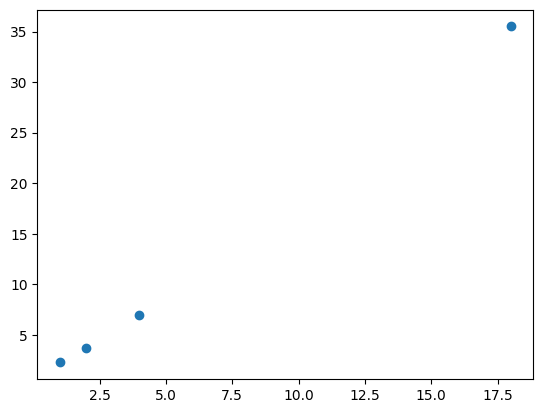

In [25]:
# `u` is twice `t`, plus a bit of randomness
u = t*2
u *= torch.randn_like(t)/10+0.95

plt.scatter(t, u);

In [26]:
prod = (t-t.mean())*(u-u.mean()); prod

tensor([ 51.67,  35.81,  11.57, 275.08])

In [27]:
prod.mean()

tensor(93.53)

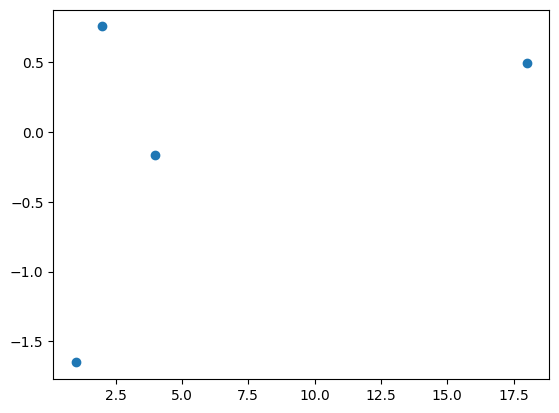

In [28]:
v = torch.randn_like(t)
plt.scatter(t, v);

In [29]:
((t-t.mean())*(v-v.mean())).mean()

tensor(2.91)

It's generally more conveniently defined like so:

$$\operatorname{E}\left[X Y\right] - \operatorname{E}\left[X\right] \operatorname{E}\left[Y\right]$$

In [30]:
cov = (t*v).mean() - t.mean()*v.mean(); cov

tensor(2.91)

From now on, you're not allowed to look at an equation (or especially type it in LaTeX) without also typing it in Python and actually calculating some values. Ideally, you should also plot some values.

Finally, here is the Pearson correlation coefficient:

$$\rho_{X,Y}= \frac{\operatorname{cov}(X,Y)}{\sigma_X \sigma_Y}$$

In [31]:
cov / (t.std() * v.std())

tensor(0.34)

It's just a scaled version of the same thing.

In [32]:
x.std()

tensor(1.13)

### Xavier init derivation

When we do `y = a @ x`, the coefficients of `y` are defined by

$$y_{i} = a_{i,0} x_{0} + a_{i,1} x_{1} + \cdots + a_{i,n-1} x_{n-1} = \sum_{k=0}^{n-1} a_{i,k} x_{k}$$

or in pure python code:
```
y[i] = sum([c*d for c,d in zip(a[i], x)])
```

or in numpy/pytorch code:
```
y[i] = (a[i]*x).sum()
```

At the very beginning, our `x` vector has a mean of roughly 0. and a standard deviation of roughly 1. (since we picked it that way).

In [33]:
x = torch.randn(100)
x.mean(), x.std()

(tensor(0.19), tensor(0.96))

If we go back to `y = a @ x` and assume that we chose weights for `a` that also have a mean of 0, we can compute the standard deviation of `y` quite easily. Since it's random, and we may fall on bad numbers, we repeat the operation 100 times.

In [34]:
mean,sqr = 0.,0.
for i in range(100):
    x = torch.randn(100)
    a = torch.randn(512, 100)
    y = a @ x
    mean += y.mean().item()
    sqr  += y.pow(2).mean().item()
mean/100,sqr/100

(-0.021637045219540595, 101.61874839782715)

Now that looks very close to the dimension of our matrix 100. And that's no coincidence! When you compute y, you sum 100 product of one element of a by one element of x. So what's the mean and the standard deviation of such a product? We can show mathematically that as long as the elements in `a` and the elements in `x` are independent, the mean is 0 and the std is 1. This can also be seen experimentally:

In [35]:
mean,sqr = 0.,0.
for i in range(10000):
    x = torch.randn(1)
    a = torch.randn(1)
    y = a*x
    mean += y.item()
    sqr  += y.pow(2).item()
mean/10000,sqr/10000

(-0.003184134499988704, 0.9690546516017775)

Then we sum 100 of those things that have a mean of zero, and a mean of squares of 1, so we get something that has a mean of 0, and mean of square of 100, hence `math.sqrt(100)` being our magic number. If we scale the weights of the matrix and divide them by this `math.sqrt(100)`, it will give us a `y` of scale 1, and repeating the product as many times as we want won't overflow or vanish.

## Kaiming/He init

("He" is a Chinese surname and is pronouced like "Her", not like "Hee".)

Kaiming Initialization (also known as He Initialization) is a method for initializing the weights of neural networks, particularly deep networks with **ReLU** activation functions. Its goal is to ensure that the weights in each layer maintain the flow of information through the network, without causing vanishing or exploding gradients. It works by setting the initial weights to random values drawn from a distribution with a specific variance that depends on the number of input units in the layer.

**Why it's used:**
- If weights are too small, the gradients vanish, making it hard to learn.
- If weights are too large, the gradients explode, causing unstable updates.
- Kaiming Initialization helps keep the activations and gradients in a reasonable range during training.

### Intermediate Explanation:

Kaiming Initialization is designed based on the properties of the **ReLU** activation function, which only passes positive values and zeroes out negative ones. ReLU introduces non-linearity in the network but it also means that approximately half of the inputs to each neuron get zeroed out. 

#### Formula:
For a layer with \( n \) input units (also called "fan-in"), the weights are initialized by drawing from a normal (or uniform) distribution with variance:

$$
\text{Var}(w) = \frac{2}{n}
$$

Where:
- \( n \) is the number of input units (fan-in).
- The factor of 2 compensates for the fact that ReLU activation “kills” about half the neurons by setting them to zero. It effectively doubles the input to balance out this loss.

#### Weight Initialization:
Weights are initialized with the following distribution:
- **Normal distribution:**  
  $$
  w \sim \mathcal{N}\left(0, \sqrt{\frac{2}{n}}\right)
  $$
- **Uniform distribution:**  
  $$
  w \sim \mathcal{U} \left( -\sqrt{\frac{6}{n}}, \sqrt{\frac{6}{n}} \right)
  $$

### Advanced Explanation:

To fully understand why Kaiming Initialization works well, let's look at a few mathematical properties.

#### Variance Preservation:
The core idea behind Kaiming Initialization is to maintain a balance of variance throughout the layers of the network. When we propagate inputs forward through the layers, if we don't properly initialize the weights, the activations could either shrink (vanishing gradients) or blow up (exploding gradients). This initialization technique ensures that the variance of the inputs and outputs stays balanced.

Let’s assume the input to a layer is \( x \), with a certain variance \( \text{Var}(x) \), and the weights are initialized from a normal distribution. If we want to ensure that the variance of the output \( \text{Var}(Wx) \) remains the same as the input variance, the weight variance needs to satisfy:

$$
\text{Var}(Wx) = \text{Var}(W) \cdot \text{Var}(x)
$$

Kaiming Initialization sets \( \text{Var}(W) = \frac{2}{n} \), ensuring that the variance of the output activations stays within the same range as the inputs.

#### ReLU Activation Considerations:
ReLU activations have some special considerations due to their asymmetric nature (i.e., zeroing out negative values). During forward propagation, approximately half of the activations are zeroed out, effectively reducing the number of active neurons. This could lead to a reduction in the signal being propagated. By doubling the variance of the weights, Kaiming Initialization compensates for this by maintaining a consistent signal strength despite the dropout of neurons.

#### Extension to Leaky ReLU:
For **Leaky ReLU**, a variation of the ReLU activation that allows a small, non-zero gradient for negative inputs, the factor of 2 used in Kaiming Initialization can be modified to account for the non-zero slope in negative values. 

If \( \alpha \) is the slope of the negative part of Leaky ReLU, the variance of the weights would be:

$$
\text{Var}(w) = \frac{2}{n(1 + \alpha^2)}
$$

This shows how Kaiming Initialization can be adapted based on the specific activation functions in use.


### Background

In [35]:
x = torch.randn(200, 100)
y = torch.randn(200)

In [36]:
from math import sqrt

In [37]:
w1 = torch.randn(100,50) / sqrt(100)
b1 = torch.zeros(50)
w2 = torch.randn(50,1) / sqrt(50)
b2 = torch.zeros(1)

In [38]:
def lin(x, w, b): return x @ w + b

In [39]:
l1 = lin(x, w1, b1)
l1.mean(),l1.std()

(tensor(0.01), tensor(0.98))

In [40]:
def relu(x): return x.clamp_min(0.)

In [41]:
l2 = relu(l1)
l2.mean(),l2.std()

(tensor(0.40), tensor(0.58))

In [42]:
x = torch.randn(200, 100)
for i in range(50): x = relu(x @ (torch.randn(100,100) * 0.1))
x[0:5,0:5]

tensor([[    0.00,     0.00,     0.00,     0.00,     0.00],
        [    0.00,     0.00,     0.00,     0.00,     0.00],
        [    0.00,     0.00,     0.00,     0.00,     0.00],
        [    0.00,     0.00,     0.00,     0.00,     0.00],
        [    0.00,     0.00,     0.00,     0.00,     0.00]])

In ["Delving Deep into Rectifiers: Surpassing Human-Level Performance"](https://arxiv.org/abs/1502.01852) Kaiming He et al. show that we should use the following scale instead: $\sqrt{2 / n_{in}}$, where $n_{in}$ is the number of inputs of our model.

In [43]:
x = torch.randn(200, 100)
for i in range(50): x = relu(x @ (torch.randn(100,100) * sqrt(2/100)))
x[0:5,0:5]

tensor([[0.40, 0.00, 0.00, 0.28, 0.00],
        [0.37, 0.00, 0.00, 0.30, 0.00],
        [0.28, 0.00, 0.00, 0.20, 0.00],
        [0.36, 0.00, 0.00, 0.30, 0.00],
        [0.25, 0.00, 0.00, 0.19, 0.00]])

### Applying an init function

In [44]:
model = get_model()
model.apply(lambda m: print(type(m).__name__));

Conv2d
ReLU
Sequential
Conv2d
ReLU
Sequential
Conv2d
ReLU
Sequential
Conv2d
ReLU
Sequential
Conv2d
Flatten
Sequential


In [45]:
def init_weights(m):
    if isinstance(m, (nn.Conv1d,nn.Conv2d,nn.Conv3d)): init.kaiming_normal_(m.weight)

In [46]:
model.apply(init_weights);

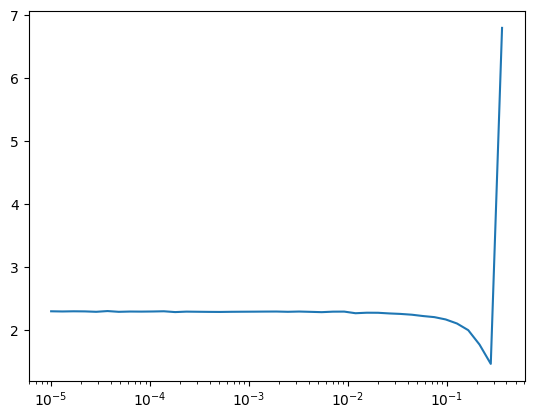

In [47]:
MomentumLearner(model, dls, F.cross_entropy, cbs=[DeviceCB()]).lr_find()

In [48]:
set_seed(42)
learn = MomentumLearner(get_model().apply(init_weights), dls, F.cross_entropy, lr=0.2, cbs=cbs)

accuracy,loss,epoch,train
0.261,2.129,0,train
0.137,5.127,0,eval
0.528,1.404,1,train
0.765,0.623,1,eval
0.805,0.530,2,train
0.803,0.541,2,eval


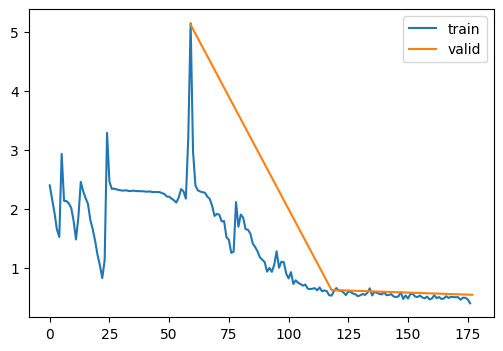

In [49]:
learn.fit(3)

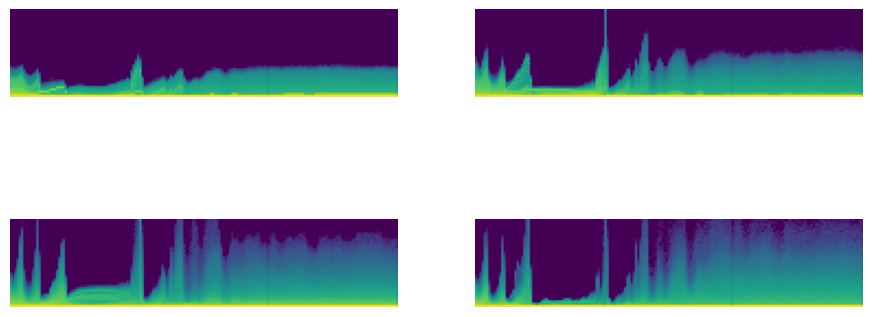

In [50]:
astats.color_dim()

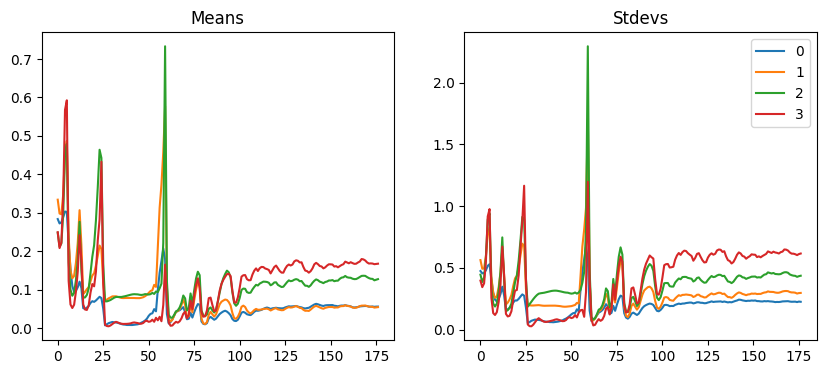

In [51]:
astats.plot_stats()

## Input normalization

In [52]:
xmean,xstd = xb.mean(),xb.std()
xmean,xstd

(tensor(0.29), tensor(0.35))

In [53]:
#| export
class BatchTransformCB(Callback):
    def __init__(self, tfm, on_train=True, on_val=True): fc.store_attr()

    def before_batch(self, learn):
        if (self.on_train and learn.training) or (self.on_val and not learn.training):
            learn.batch = self.tfm(learn.batch)

In [54]:
def _norm(b): return (b[0]-xmean)/xstd,b[1]
norm = BatchTransformCB(_norm)

Normalizes the first element of the input tuple `b` by centering around `xmean` and scaling by `xstd`. `xmean` is the mean of the data, and `xstd` is the standard deviation. This ensures that the feature has a mean of 0 and a standard deviation of 1, which helps improve model performance and stability. The second element of `b` is returned unchanged.

accuracy,loss,epoch,train
0.477,1.581,0,train
0.717,0.737,0,eval
0.790,0.555,1,train
0.803,0.509,1,eval
0.834,0.440,2,train
0.835,0.458,2,eval


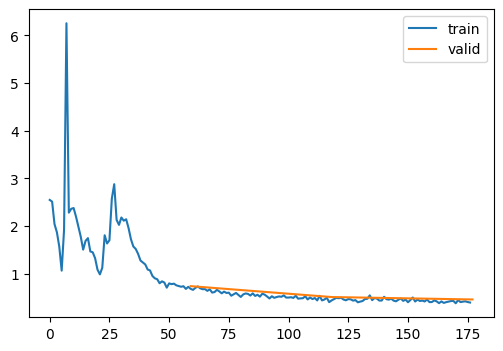

In [55]:
set_seed(42)
learn = MomentumLearner(get_model().apply(init_weights), dls, F.cross_entropy, lr=0.2, cbs=cbs+[norm])
learn.fit(3)

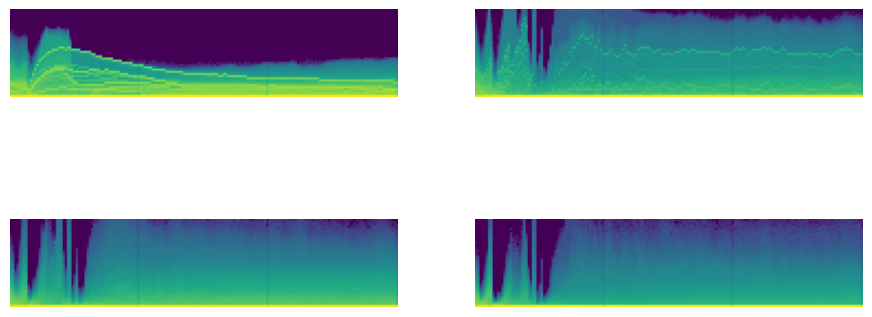

In [56]:
astats.color_dim()

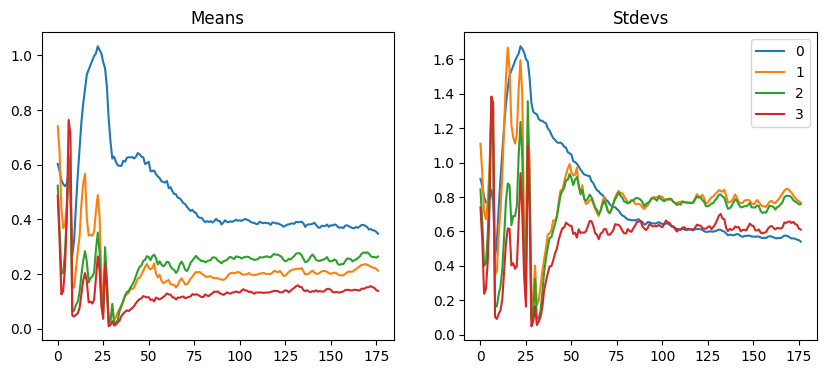

In [57]:
astats.plot_stats()

In [58]:
@inplace
def transformi(b): b[xl] = [(TF.to_tensor(o)-xmean)/xstd for o in b[xl]]
tds = dsd.with_transform(transformi)
dls = DataLoaders.from_dd(tds, bs, num_workers=4)
xb,yb = next(iter(dls.train))

In [59]:
xb.mean(),xb.std()

(tensor(0.01), tensor(1.00))

## General ReLU

In [60]:
#| export
class GeneralRelu(nn.Module):
    def __init__(self, leak=None, sub=None, maxv=None):
        super().__init__()
        self.leak,self.sub,self.maxv = leak,sub,maxv

    def forward(self, x): 
        x = F.leaky_relu(x,self.leak) if self.leak is not None else F.relu(x)
        if self.sub is not None: x -= self.sub
        if self.maxv is not None: x.clamp_max_(self.maxv)
        return x

### Leak (Leaky ReLU behavior):
- **Parameter**: `leak`
- **Function**: If `leak` is provided, the activation will use **Leaky ReLU** instead of the standard ReLU. Leaky ReLU allows a small, non-zero gradient for negative input values, preventing them from being completely "killed" as in regular ReLU.
  
  **Leaky ReLU**:
  $$
  f(x) =
  \begin{cases}
    x & \text{if } x > 0 \\
    \alpha x & \text{if } x \leq 0
  \end{cases}
  $$
  Where \( \alpha = \text{leak} \), a small constant typically less than 1 (e.g., 0.01).

- **Significance**: Using Leaky ReLU can prevent the **"dying ReLU problem"** where neurons outputting negative values become inactive, especially in deeper networks. If `leak` is `None`, the model will use standard ReLU by default.

### Subtraction (Offset adjustment):
- **Parameter**: `sub`
- **Function**: If `sub` is provided, a constant value is subtracted from the output after the activation (either ReLU or Leaky ReLU). This allows you to shift the output of the activation function.
  
  $$
  x = x - \text{sub}
  $$

- **Significance**: This can be useful for fine-tuning the activation range. By subtracting a constant value, you can lower the threshold for positive activations or allow some negative values to pass through. This is a way to center the activation output around a different value, potentially improving training dynamics for certain tasks.

### Max Value Clamping (Upper bound control):
- **Parameter**: `maxv`
- **Function**: If `maxv` is provided, the activation output is clamped to a maximum value. This means that any values greater than `maxv` will be clipped to `maxv`.
  
  $$
  x = \min(x, \text{maxv})
  $$

- **Significance**: Clamping the output helps control the range of the activations, ensuring they don’t grow too large. This can stabilize training, especially in deep networks where large activations can lead to exploding gradients. It also provides a way to ensure bounded outputs in applications where the range is important.

### Forward Method:
- **Function**: 
  - First, it applies Leaky ReLU if `leak` is specified, or standard ReLU otherwise.
  - Then, if `sub` is provided, it subtracts this constant from the activation output.
  - Finally, if `maxv` is specified, the output is clamped to ensure it doesn’t exceed the maximum value.


In [61]:
#| export
def plot_func(f, start=-5., end=5., steps=100):
    x = torch.linspace(start, end, steps)
    plt.plot(x, f(x))
    plt.grid(True, which='both', ls='--')
    plt.axhline(y=0, color='k', linewidth=0.7)
    plt.axvline(x=0, color='k', linewidth=0.7)

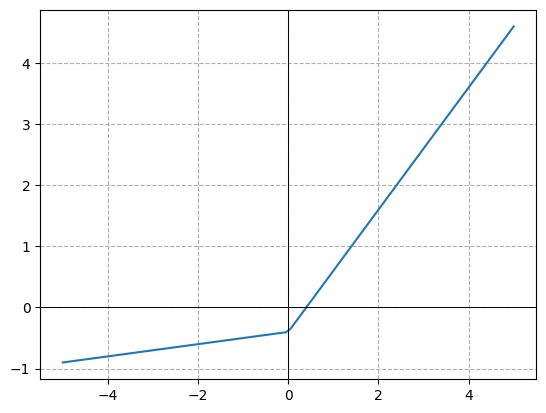

In [62]:
plot_func(GeneralRelu(leak=0.1, sub=0.4))

In [63]:
def conv(ni, nf, ks=3, stride=2, act=nn.ReLU):
    res = nn.Conv2d(ni, nf, stride=stride, kernel_size=ks, padding=ks//2)
    if act: res = nn.Sequential(res, act())
    return res

### 1. **Function Parameters**

```
def conv(ni, nf, ks=3, stride=2, act=nn.ReLU):
```

- **`ni` (Number of Input Channels):**  
  Specifies the number of input channels to the convolutional layer. This is typically the depth of the input feature map (e.g., for RGB images, `ni` is 3).
  
- **`nf` (Number of Output Channels):**  
  Specifies the number of output channels (filters) after the convolution is applied. Each filter will generate a separate output feature map, so `nf` controls the depth of the output.

- **`ks=3` (Kernel Size):**  
  Determines the size (height and width) of the convolutional kernel or filter. By default, it is set to 3, meaning a 3x3 filter will be applied.

- **`stride=2` (Stride):**  
  Controls the step size of the convolutional filter when it moves across the input. A stride of 2 means that the filter shifts 2 pixels at a time, which downsamples the input by reducing its spatial dimensions (width and height).

- **`act=nn.ReLU` (Activation Function):**  
  Specifies the activation function to be applied after the convolution operation. By default, this is set to ReLU (Rectified Linear Unit), but it can be changed to other activations (like `nn.Sigmoid` or `nn.LeakyReLU`). If you pass `None` for `act`, no activation will be applied.

### 2. **Convolutional Layer Construction**

```
res = nn.Conv2d(ni, nf, stride=stride, kernel_size=ks, padding=ks//2)
```

- **`nn.Conv2d(ni, nf, stride=stride, kernel_size=ks, padding=ks//2)`**  
  This line constructs the core convolutional layer using PyTorch's `Conv2d` function. Here's what each part does:
  
  - **`ni` (in_channels):** Number of input channels (depth of the input).
  - **`nf` (out_channels):** Number of output channels (filters).
  - **`stride=stride`:** How much the filter moves at each step. A stride of 2 reduces the spatial size of the output by half compared to the input size.
  - **`kernel_size=ks`:** Size of the convolutional filter, which is `3x3` by default.
  - **`padding=ks//2`:** Padding adds pixels around the border of the input to control the output size. For a `3x3` kernel (`ks=3`), `ks//2` results in `1`, which adds a single layer of padding. This is called "same padding" and ensures the output height and width are roughly the same as the input when `stride=1`.

### 3. **Adding the Activation Function (Optional)**

```python
if act: res = nn.Sequential(res, act())
```

- **`if act:`**  
  This checks if the `act` parameter is not `None`. If `act` is specified (default is `nn.ReLU`), it applies the activation function after the convolutional layer.

- **`res = nn.Sequential(res, act())`:**  
  Combines the convolutional layer (`res`) and the activation function (`act()`) into a sequential container (`nn.Sequential`). This ensures that both operations (convolution and activation) are applied in sequence. 

  - **`nn.Sequential`:** A container that chains together layers and operations to be applied in order. In this case, it applies the convolution first, followed by the activation.

### Example

For `conv(1, 8)`, the function will:

1. Create a convolutional layer with 1 input channel, 8 output channels, a 3x3 kernel, and a stride of 2.
2. Apply a ReLU activation function after the convolution.
3. Return the resulting layer, which is a `nn.Sequential` container with the convolution and ReLU applied in sequence.

If `act=None` is passed, only the convolutional layer will be created, without any activation applied afterward.

In [64]:
def get_model(act=nn.ReLU, nfs=None):
    if nfs is None: nfs = [1,8,16,32,64]
    layers = [conv(nfs[i], nfs[i+1], act=act) for i in range(len(nfs)-1)]
    return nn.Sequential(*layers, conv(nfs[-1],10, act=None), nn.Flatten()).to(def_device)

In [65]:
#| export
def init_weights(m, leaky=0.):
    if isinstance(m, (nn.Conv1d,nn.Conv2d,nn.Conv3d)): init.kaiming_normal_(m.weight, a=leaky)

In [66]:
act_gr = partial(GeneralRelu, leak=0.1, sub=0.4)
astats = ActivationStats(fc.risinstance(GeneralRelu))
cbs = [DeviceCB(), metrics, ProgressCB(plot=True), astats]
iw = partial(init_weights, leaky=0.1)

In [67]:
model = get_model(act_gr).apply(iw)

accuracy,loss,epoch,train
0.731,0.800,0,train
0.840,0.436,0,eval
0.865,0.368,1,train
0.864,0.376,1,eval
0.881,0.325,2,train
0.869,0.365,2,eval


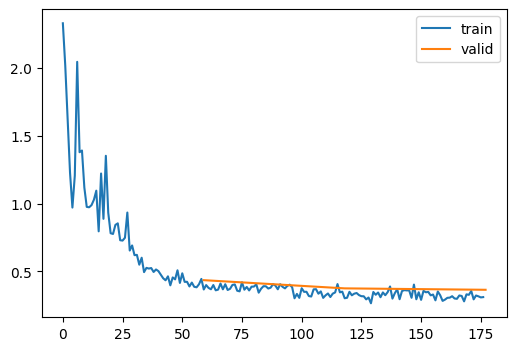

In [68]:
set_seed(42)
learn = MomentumLearner(model, dls, F.cross_entropy, lr=0.2, cbs=cbs)
learn.fit(3)

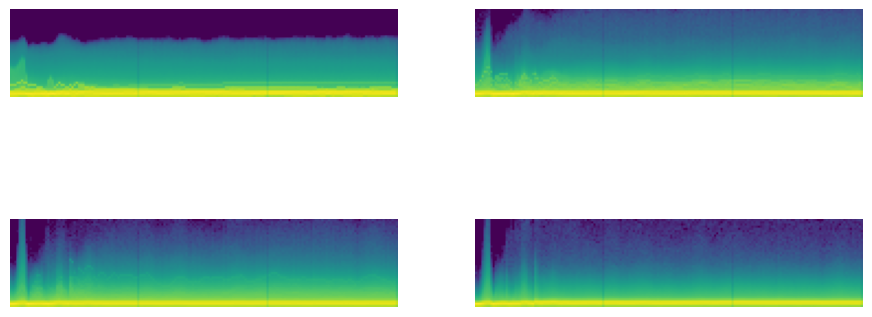

In [69]:
astats.color_dim()

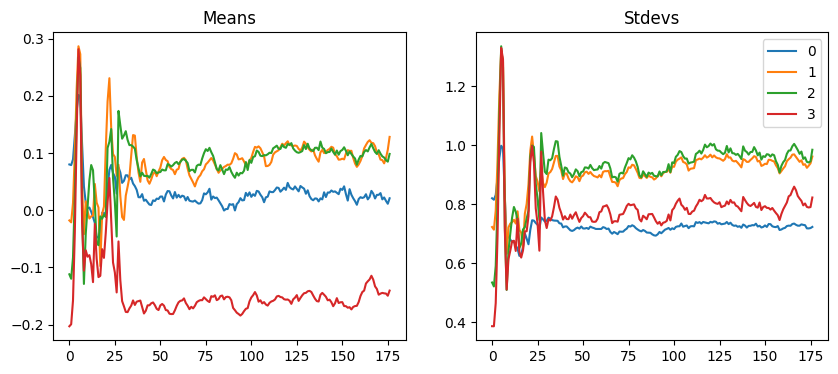

In [70]:
astats.plot_stats()

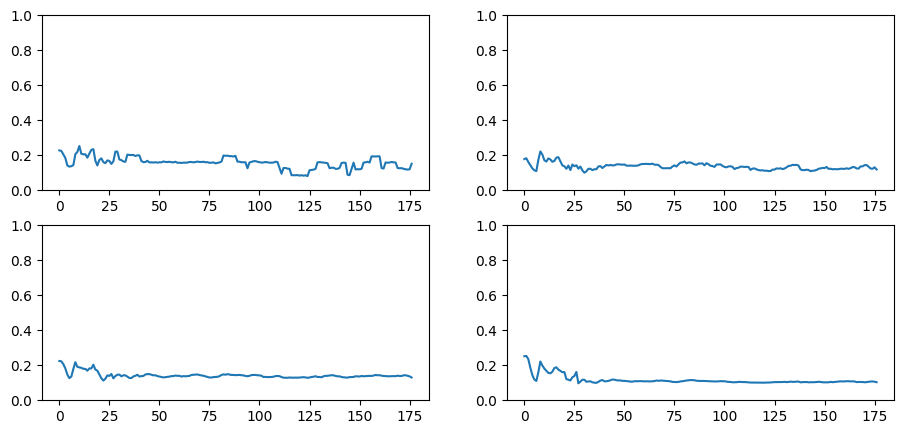

In [71]:
astats.dead_chart()

## LSUV

[All You Need is a Good Init](https://arxiv.org/pdf/1511.06422.pdf) introduces *Layer-wise Sequential Unit-Variance* (*LSUV*).

### The Problem with Initialization

When training deep neural networks, proper initialization of weights is crucial for good performance. Poor initialization can lead to slow convergence or even training failure. The traditional methods like Xavier (Glorot) or He initialization aim to address this, but LSUV proposes a more refined approach.

### LSUV Initialization Overview

**Layer-wise Sequential Unit-Variance (LSUV)** is a technique designed to ensure that the activations and gradients within a network have unit variance. The basic idea is to initialize the network such that the variance of activations and gradients remains stable across layers, which can significantly improve the training process.

### How LSUV Works

Here's a step-by-step overview of how LSUV initialization is applied:

#### re-initialization

- Start with a standard initialization (e.g., Xavier or He).
- This initialization provides a baseline, but the variance of activations and gradients may still vary across layers.

#### Forward Pass and Normalization

- Perform a forward pass through the network with the pre-initialized weights.
- Compute the mean and variance of activations for each layer.
- Normalize the activations to have unit variance for each layer.

#### Adjust Weights

- Adjust the weights of each layer based on the computed variance from the previous step.
- This adjustment involves scaling the weights to ensure that the variance of activations remains close to one.

#### Iterate

- Repeat the forward pass and normalization steps until the activations across all layers have unit variance.

### Benefits of LSUV

- **Improved Training Stability**: By maintaining a stable variance throughout the network, LSUV helps prevent issues like vanishing or exploding gradients, leading to more stable training.
- **Faster Convergence**: Networks initialized with LSUV often converge faster because they start from a point where the activations and gradients are well-behaved.
- **Better Performance**: Empirical results show that networks with LSUV initialization can achieve better performance compared to those with traditional initialization methods.

### Example Workflow

1. **Initialize**: Use Xavier or He initialization for your network weights.
2. **Forward Pass**: Perform a forward pass to compute activations.
3. **Normalize**: Calculate the variance of activations and normalize them to have unit variance.
4. **Adjust**: Scale the weights based on the computed variance.
5. **Repeat**: Continue the process until variance across all layers is consistent.
6. **Train**: Proceed with the training of your network using standard techniques.

By following these steps, you can leverage LSUV to improve your network's initialization and potentially enhance its training efficiency and performance.

Xavier and Kaiming initialize weights based on theoretical variance calculations to ensure stable gradients but do not adjust based on actual activation variance during training.

LSUV dynamically adjusts weights based on the observed variance of activations after an initial forward pass, aiming for a more stable and consistent network behavior throughout training.

In [72]:
#| export
def _lsuv_stats(hook, mod, inp, outp):
    acts = to_cpu(outp)
    hook.mean = acts.mean()
    hook.std = acts.std()

def lsuv_init(model, m, m_in, xb):
    h = Hook(m, _lsuv_stats)
    with torch.no_grad():
        while model(xb) is not None and (abs(h.std-1)>1e-3 or abs(h.mean)>1e-3):
            m_in.bias -= h.mean
            m_in.weight.data /= h.std
    h.remove()

In [73]:
model = get_model(act_gr)
relus = [o for o in model.modules() if isinstance(o, GeneralRelu)]
convs = [o for o in model.modules() if isinstance(o, nn.Conv2d)]

In [74]:
for ms in zip(relus,convs): print(ms)

(GeneralRelu(), Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1)))
(GeneralRelu(), Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1)))
(GeneralRelu(), Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1)))
(GeneralRelu(), Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1)))


In [75]:
for ms in zip(relus,convs): lsuv_init(model, *ms, xb.to(def_device))

accuracy,loss,epoch,train
0.769,0.658,0,train
0.834,0.458,0,eval
0.862,0.377,1,train
0.854,0.399,1,eval
0.877,0.335,2,train
0.860,0.379,2,eval


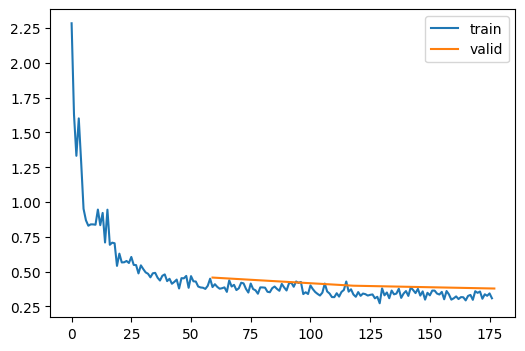

In [76]:
set_seed(42)
learn = MomentumLearner(model, dls, F.cross_entropy, lr=0.2, cbs=cbs)
learn.fit(3)

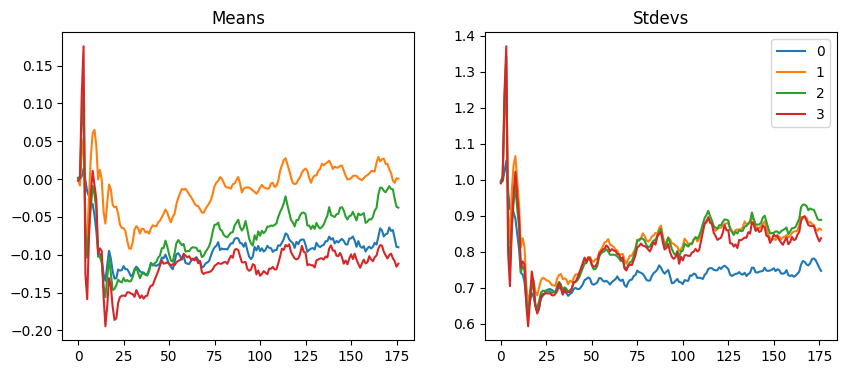

In [77]:
astats.plot_stats()

## Batch Normalization

Sergey Ioffe and Christian Szegedy released ["Batch Normalization: Accelerating Deep Network Training by Reducing Internal Covariate Shift"](https://arxiv.org/abs/1502.03167) in 2015, saying:

> Training Deep Neural Networks is complicated by the fact that the distribution of each layer's inputs changes during training, as the parameters of the previous layers change. This slows down the training by requiring lower learning rates and careful parameter initialization... We refer to this phenomenon as internal covariate shift, and address the problem by normalizing layer inputs.

Their proposal is:

> Making normalization a part of the model architecture and performing the normalization for each training mini-batch. Batch Normalization allows us to use much higher learning rates and be less careful about initialization.

### Introduction to the Problem

**Internal Covariate Shift:**
- In deep neural networks, as training progresses, the distribution of activations (outputs of each layer) changes because of updates to the weights of previous layers. This phenomenon is known as internal covariate shift.
- Internal covariate shift can slow down training and make it harder to converge, as each layer needs to adapt to the new distribution of activations.

### What is Batch Normalization?

**Basic Concept:**
- Batch Normalization (BatchNorm) is a technique to normalize the activations of a neural network layer by adjusting and scaling the activations.
- It reduces internal covariate shift by normalizing the activations of each layer, making the training process more stable and faster.

**How It Works:**
1. **Normalize Activations:**
   - For each mini-batch, compute the mean and variance of activations.
   - Normalize the activations by subtracting the mean and dividing by the standard deviation.

2. **Scale and Shift:**
   - After normalization, apply a learnable scaling factor ($\gamma$) and a learnable shift factor ($\beta$) to the normalized activations.
   - This allows the network to adjust the normalized output, preserving the representational power.

### Mathematical Details

**Normalization Equation:**
- Given a layer’s activation $x$ for a mini-batch:
  $$
  \hat{x} = \frac{x - \mu_B}{\sqrt{\sigma_B^2 + \epsilon}}
  $$
  where:
  - $\mu_B$ is the mean of the batch.
  - $\sigma_B^2$ is the variance of the batch.
  - $\epsilon$ is a small constant to prevent division by zero.

**Scaling and Shifting:**
- After normalization, apply:
  $$
  y = \gamma \hat{x} + \beta
  $$
  where:
  - $\gamma$ and $\beta$ are learnable parameters.

### Why Does It Work?

**Stabilizing Learning:**
- By normalizing activations, BatchNorm reduces the internal covariate shift, leading to more stable gradients and faster convergence.
- It makes the optimization process smoother, allowing for higher learning rates and reducing the need for careful tuning of learning rates.

**Regularization Effect:**
- BatchNorm has a slight regularization effect due to the mini-batch statistics being used. This can reduce the need for other forms of regularization like dropout.

### Training vs. Inference

**Training Phase:**
- During training, BatchNorm uses the statistics of the current mini-batch to normalize activations.

**Inference Phase:**
- During inference (or evaluation), the statistics are not computed from the mini-batch. Instead, the running average of the mean and variance, accumulated during training, is used.

### Practical Considerations

- BatchNorm is typically applied after the linear transformation (e.g., fully connected layer or convolution) and before the activation function (e.g., ReLU).

- BatchNorm can significantly accelerate training and improve the performance of deep networks.

### Advanced Insights

**BatchNorm and Depth:**
- BatchNorm is particularly useful for very deep networks, where internal covariate shift is more pronounced. It helps in training very deep architectures by stabilizing the activations and gradients.

**Layer-wise Normalization:**
- While BatchNorm normalizes activations layer-wise, there are other normalization techniques like Layer Normalization and Instance Normalization that address different use cases or are applicable in specific contexts.

**Research Extensions:**
- Variants of BatchNorm, such as Group Normalization and Layer Normalization, have been developed to address limitations in specific settings, such as when batch sizes are very small or in non-convolutional networks.

### LayerNorm

We'll start with [layer normalization](https://arxiv.org/abs/1607.06450), a simpler technique.

**Concept:**
- LayerNorm normalizes the activations of each layer across the features, not across the batch. This means that normalization is applied to each sample individually.

**How It Works:**
1. **Compute Statistics:**
   - For each feature, compute the mean ($\mu$) and variance ($\sigma^2$) across all activations of the same sample.

2. **Normalize:**
   - Normalize the activations using the computed mean and variance:
     $$
     \hat{x} = \frac{x - \mu}{\sqrt{\sigma^2 + \epsilon}}
     $$
     where $\epsilon$ is a small constant to prevent division by zero.

3. **Scale and Shift:**
   - Apply learnable scaling ($\gamma$) and shifting ($\beta$) parameters:
     $$
     y = \gamma \hat{x} + \beta
     $$

**Advantages:**
- **Independence from Batch Size:** Unlike BatchNorm, LayerNorm does not depend on batch size, making it suitable for tasks where batch sizes are small or vary.
- **Stabilizes Training:** Helps in stabilizing training and improving convergence by reducing internal covariate shift within each sample.

**Use Cases:**
- Often used in natural language processing models like transformers where batch sizes can be small and varying.

LayerNorm provides normalization on a per-sample basis, as opposed to BatchNorm's per-mini-batch approach, making it versatile for different types of models and tasks.


In [79]:
class LayerNorm(nn.Module):
    def __init__(self, dummy, eps=1e-5):
        super().__init__()
        self.eps = eps
        self.mult = nn.Parameter(tensor(1.))
        self.add  = nn.Parameter(tensor(0.))

    def forward(self, x):
        m = x.mean((1,2,3), keepdim=True)
        v = x.var ((1,2,3), keepdim=True)
        x = (x-m) / ((v+self.eps).sqrt())
        return x*self.mult + self.add

In [80]:
#|export
def conv(ni, nf, ks=3, stride=2, act=nn.ReLU, norm=None, bias=None):
    if bias is None: bias = not isinstance(norm, (nn.BatchNorm1d,nn.BatchNorm2d,nn.BatchNorm3d))
    layers = [nn.Conv2d(ni, nf, stride=stride, kernel_size=ks, padding=ks//2, bias=bias)]
    if norm: layers.append(norm(nf))
    if act: layers.append(act())
    return nn.Sequential(*layers)

In [81]:
#|export
def get_model(act=nn.ReLU, nfs=None, norm=None):
    if nfs is None: nfs = [1,8,16,32,64]
    layers = [conv(nfs[i], nfs[i+1], act=act, norm=norm) for i in range(len(nfs)-1)]
    return nn.Sequential(*layers, conv(nfs[-1],10, act=None, norm=False, bias=True),
                         nn.Flatten()).to(def_device)

accuracy,loss,epoch,train
0.788,0.583,0,train
0.839,0.439,0,eval
0.865,0.369,1,train
0.862,0.377,1,eval
0.880,0.328,2,train
0.856,0.395,2,eval


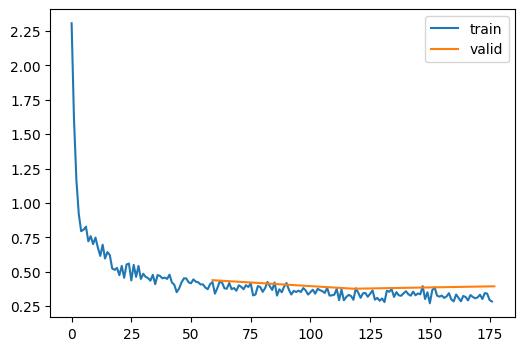

In [82]:
set_seed(42)
model = get_model(act_gr, norm=LayerNorm).apply(iw)
learn = MomentumLearner(model, dls, F.cross_entropy, lr=0.2, cbs=cbs)
learn.fit(3)

### BatchNorm

In [83]:
class BatchNorm(nn.Module):
    def __init__(self, nf, mom=0.1, eps=1e-5):
        super().__init__()
        # NB: pytorch bn mom is opposite of what you'd expect
        self.mom,self.eps = mom,eps
        self.mults = nn.Parameter(torch.ones (nf,1,1))
        self.adds  = nn.Parameter(torch.zeros(nf,1,1))
        self.register_buffer('vars',  torch.ones(1,nf,1,1))
        self.register_buffer('means', torch.zeros(1,nf,1,1))

    def update_stats(self, x):
        m = x.mean((0,2,3), keepdim=True)
        v = x.var ((0,2,3), keepdim=True)
        self.means.lerp_(m, self.mom)
        self.vars.lerp_ (v, self.mom)
        return m,v
        
    def forward(self, x):
        if self.training:
            with torch.no_grad(): m,v = self.update_stats(x)
        else: m,v = self.means,self.vars
        x = (x-m) / (v+self.eps).sqrt()
        return x*self.mults + self.adds

accuracy,loss,epoch,train
0.793,0.571,0,train
0.844,0.455,0,eval
0.873,0.346,1,train
0.864,0.363,1,eval
0.886,0.310,2,train
0.875,0.336,2,eval


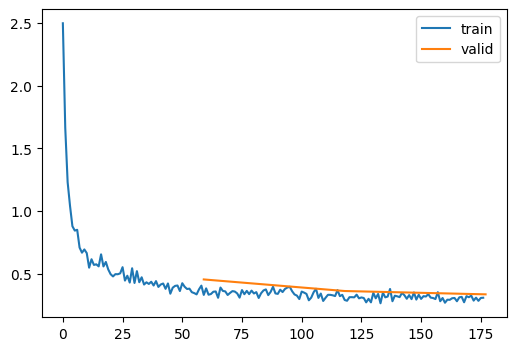

In [84]:
model = get_model(act_gr, norm=BatchNorm).apply(iw)
set_seed(42)
learn = MomentumLearner(model, dls, F.cross_entropy, lr=0.4, cbs=cbs)
learn.fit(3)

![Various norms](https://github.com/fastai/course22p2/blob/master/nbs/images/norms.png?raw=true)

## Towards 90%...

In [85]:
dls = DataLoaders.from_dd(tds, 256, num_workers=4)

accuracy,loss,epoch,train
0.835,0.450,0,train
0.859,0.381,0,eval
0.880,0.324,1,train
0.873,0.350,1,eval
0.892,0.293,2,train
0.860,0.401,2,eval


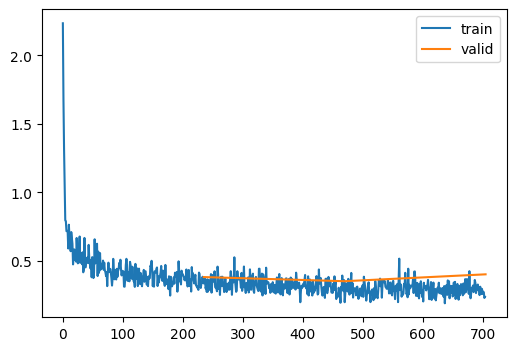

In [86]:
set_seed(42)
model = get_model(act_gr, norm=nn.BatchNorm2d).apply(iw)
learn = MomentumLearner(model, dls, F.cross_entropy, lr=0.2, cbs=cbs)
learn.fit(3)

accuracy,loss,epoch,train
0.912,0.239,0,train
0.895,0.286,0,eval
0.918,0.225,1,train
0.896,0.286,1,eval


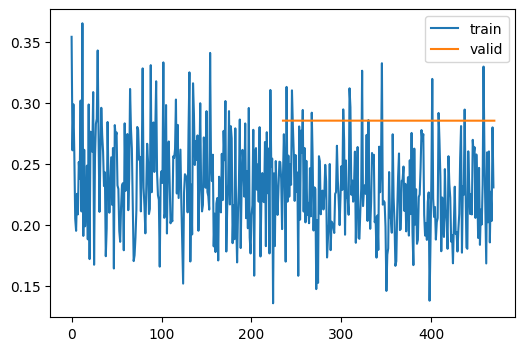

In [87]:
learn = MomentumLearner(model, dls, F.cross_entropy, lr=0.05, cbs=cbs)
learn.fit(2)

## Export -

In [ ]:
import nbdev; nbdev.nbdev_export()